# 3 Kernelized (Ridge) Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
from PIL import Image #for importing the .png file
%matplotlib inline

In [2]:
im_frame = Image.open('cc_90.png')
np_frame = np.array(im_frame.getdata())
y=np_frame[np_frame!=0]

In [3]:
xx,yy=np.meshgrid(np.arange(250),np.arange(338))
coord=np.vstack((xx.ravel(),yy.ravel())).T
X=coord[np_frame!=0]

In [4]:
#display the image
def displayImag(yFinal):
    plt.figure(figsize=(10,25/3))
    plt.gray()
    plt.imshow(yFinal.reshape((338,250)))
    plt.axis('off')

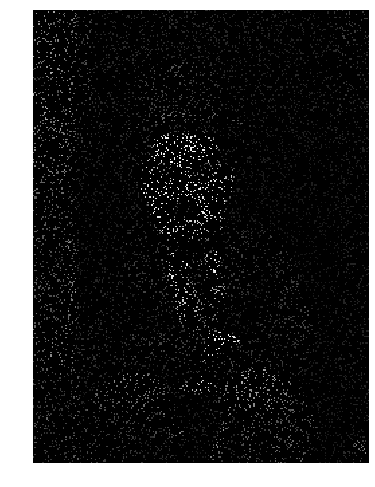

In [5]:
displayImag(np_frame)

In [6]:
def distanceSquaredMatrix(A,B):
    return np.sum(np.square(A[:,None]-B),axis=2)

In [7]:
#kernel function
def K(X1,X2,sig=5):
    dist=distanceSquaredMatrix(X1,X2)
    kernel=np.zeros(dist.shape)
    cutoff=2*sig*np.log(10) #0 when kernel function would be smaller than 0.01
    kernel[dist<cutoff]=np.exp(-dist[dist<cutoff]/(2*sig))
    return kernel


In [8]:
def buildG(X,sig=2):
    return sp.csc_matrix(K(X,X,sig))

In [9]:
def buildAlpha(G,tau):
    '''
    calculates a NxN matrix. if multiplied with y^T it becomes the alpha from the exercise
    '''
    N=G.shape[0]
    return (G+tau*sp.identity(N,format='csc'))
def newRegressed(Xnew,X,y,alpha,tau=5):
    '''
    Xnew: numpy.ndarray of new features
    X: numpy.ndarray used to build G
    y: numpy.ndarray labels of X
    G: numpy.ndarray Gram matrix
    tau: regularization parameter
    returns numpy.ndarray with regressed values for Xnew
    '''
    #calculate kappa
    kappa=K(X,Xnew,tau)
    psi=sLA.spsolve(alpha,kappa)
    
    return y.T@psi

In [17]:
#function to tune the hyper parameters
def ridgeRegression(tau,sig,steps=500):
    G=buildG(X,sig)
    alpha=buildAlpha(G,tau)
    yReg=[]
    #stepwise calculation because we had memory problems
    for i in range(int(np.ceil(len(coord)/steps))):
        yReg.append(newRegressed(coord[i*steps:(i+1)*steps],X,y,alpha,tau))
        print('%i values calculated'%(steps*(i+1)),end='\r')
    return np.concatenate(yReg).ravel()

In [76]:
def displayImages(imag,label):
    plt.figure(figsize=(13,19))
    n=int(np.sqrt(len(imag)))
    for i in range(len(imag)):
        plt.subplot(np.ceil(len(imag)/n),n,i+1)
        plt.axis('off')
        title= r'$\tau=%.1f,\ \sigma=%.1f$'%(*label[i],) if type(label[i])==list else r'$\sigma=%.1f$'%(label[i])
        plt.title(title)
        plt.imshow(imag[i].reshape((338,250)))

In [21]:
hyperparameters=[[3,10],[5,10],[4,15],[3.5,20]]

In [11]:
yF310=ridgeRegression(*hyperparameters[0])

In [12]:
yF510=ridgeRegression(*hyperparameters[1])

In [16]:
yF415=ridgeRegression(*hyperparameters[2])

In [23]:
yF3520=ridgeRegression(*hyperparameters[3])

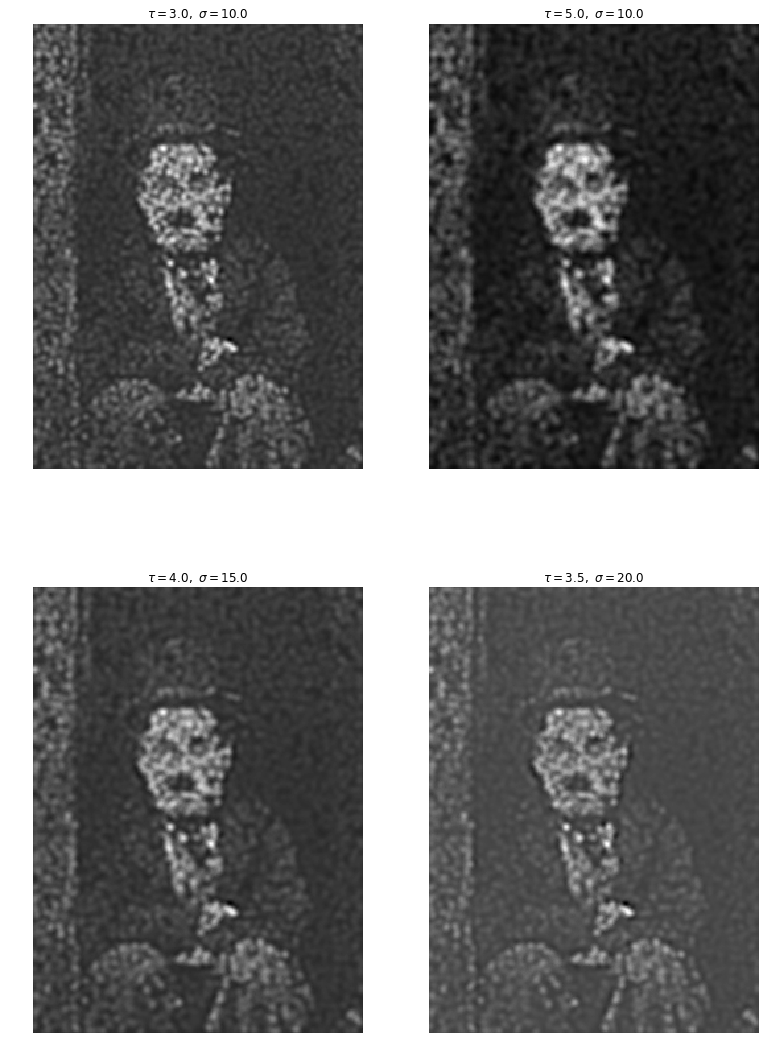

In [78]:
displayImages([yF310,yF510,yF415,yF3520],hyperparameters)

We can recognize charlie chaplin
![Original](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Chaplin_The_Kid_edit.jpg/220px-Chaplin_The_Kid_edit.jpg)

In [67]:
def nadarayaWatsonKernel(Xnew,X,y,sig=3):
    '''
    Xnew: numpy.ndarray of new features
    X: numpy.ndarray used to build G
    y: numpy.ndarray labels of X
    tau: regularization parameter
    returns numpy.ndarray with regressed values for Xnew
    '''
    #calculate kappa
    kappa=K(X,Xnew,sig)
    sumKappa=np.sum(kappa,axis=0)
    sumKappa[sumKappa==0]=np.inf
    return (y.T@kappa)/sumKappa

In [68]:
#function to tune the hyper parameters
def nadarayaWatsonRegression(sig,steps=1000):
    yReg=[]
    #stepwise calculation because we had memory problems
    for i in range(int(np.ceil(len(coord)/steps))):
        yReg.append(nadarayaWatsonKernel(coord[i*steps:(i+1)*steps],X,y,sig))
        print('%i values calculated'%(steps*(i+1)),end='\r')
    return np.concatenate(yReg).ravel()

In [79]:
sigs=[2,3,4,5]
yNW=[]
for i in range(len(sigs)):
    yNW.append(nadarayaWatsonRegression(sigs[i],2000))

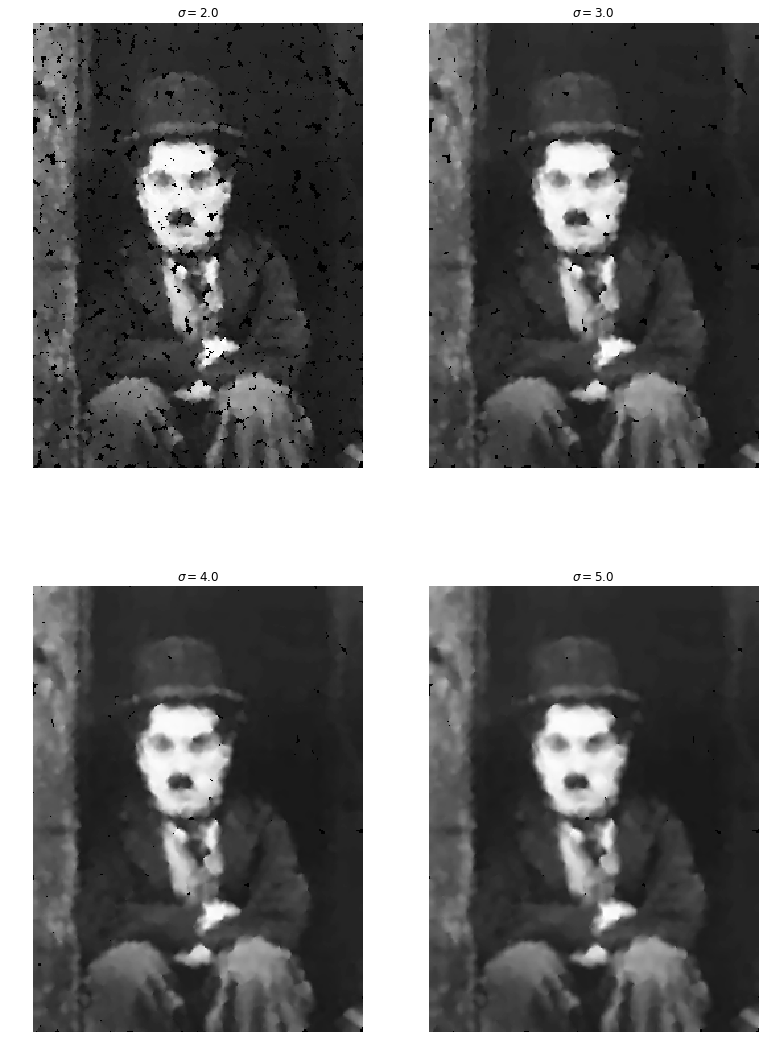

In [80]:
displayImages(yNW,sigs)

With both methods one can recognize Charlie Chaplin. Using the ridge regression there were still dots recognizable. Also for a bigger $\sigma$ the regression took a very long time. Using the Nadaraya Watson Regression the resulting pictures were arguably better and it took less time. With this one we could even reverse image search the picture to get the ground truth
![Ground truth](http://shared.frenys.com/assets/1014754/6079880-Une-journee-sans-rire-est-une-journee-de-perdue.jpg)